# Imports

In [1]:
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
import sys
sys.path.insert(0,'../../')

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [3]:
#save a slice
filename = 'jokes_dataset.csv'
raw_df = pd.read_csv('../data/'+filename, sep=',',
                encoding='utf-8').set_index('id')

# work with copy
df = raw_df.copy(deep=True)

# Preprocessing

In [4]:
from src import schema as S
from src.preprocessing.preprocessing import SimplePreprocessor
from bs4 import BeautifulSoup

preprocessor = SimplePreprocessor()

# Dataset augmenting

In [5]:
import nlpaug.augmenter.word as naw

aug_syn = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=1)

In [6]:
from src.augmenting.augmenting import Augmenter

augmenter = Augmenter(aug_syn)

# Dataset convertor

In [7]:
from src.text2seq.convertor import Text2SeqConvertor

convertor = Text2SeqConvertor()

# Model

In [8]:
# from src.models.CNN_simple import CNNSimple

In [25]:
import torch.nn as nn
import src.schema as S


class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim

    def forward(self, x):
        return x.max(dim=self.dim)[0]


class JokeRankPredictor(nn.Module):
    def __init__(self, n_tokens, hid_size=256):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)

        self.joke_encoder = nn.Sequential(
            nn.Conv1d(hid_size, 128, kernel_size=3),
            nn.Sigmoid(),
            GlobalMaxPooling(),
            # nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.final_predictor = nn.Sequential(
            nn.Linear(128, 50),
            nn.Dropout(p=0.5),
            nn.Sigmoid(),
            # nn.BatchNorm1d(hid_size),
            nn.Linear(50, 5),
            nn.Softmax(dim=-1)
        )

    def forward(self, batch):
        joke_embeddings = self.embedder(batch[S.JOKE]).permute(0, 2, 1)
        joke_features = self.joke_encoder(joke_embeddings).squeeze()

        return self.final_predictor(joke_features).squeeze()

# Pipline

In [27]:
from src.pipeline.pipeline import Pipeline

pipeline = Pipeline(
                 preprocessor = preprocessor,
                 augmenter = augmenter,
                 convertor = convertor,
                 model = JokeRankPredictor, 
                 splitting_params = {'test_size': 0.2,
                                     'shuffle': True},
                 )


In [28]:
 %%time
train_df, val_df, test_df = pipeline.prepare_data(df)

DEBUG:pipeline-log:Starting preprocessing
DEBUG:pipeline-log:Splitting dataset on train, val and test
DEBUG:pipeline-log:Augment text for train
DEBUG:pipeline-log:Make vocabulary
DEBUG:pipeline-log:Split data to train/val/test after making vocabulary
Wall time: 13min 32s


In [29]:
train_df.shape, val_df.shape ,test_df.shape

((243270, 3), (30409, 3), (38012, 3))

# Train

In [30]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [ ]:
iteration_list, loss_list, accuracy_list = pipeline.train_model(learning_rate,
                                                               criterion,
                                                               optimizer,
                                                               train_df,
                                                               val_df,
                                                               epochs=5,
                                                               checkpoint_path='../checkpoints/cnn_simple_best_checkpoint')

INFO:pipeline-log:Training model
INFO:pipeline-log:*** <class '__main__.JokeRankPredictor'>
Epoch 0


  0%|          | 0/1900 [00:00<?, ?it/s]

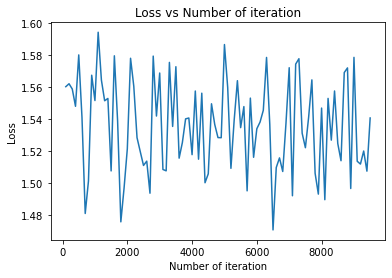

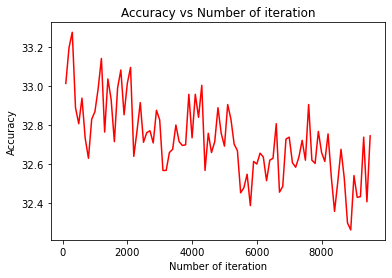

In [22]:
pipeline.draw_curves(iteration_list, loss_list, accuracy_list)

# Predict

In [23]:
pred = pipeline.predict(test_df, checkpoint_path='../checkpoints/cnn_simple_best_checkpoint')

INFO:pipeline-log:Starting prediction
Loading checkpoint '../checkpoints/cnn_simple_best_checkpoint'
Loaded checkpoint '../checkpoints/cnn_simple_best_checkpoint' from iteration 299


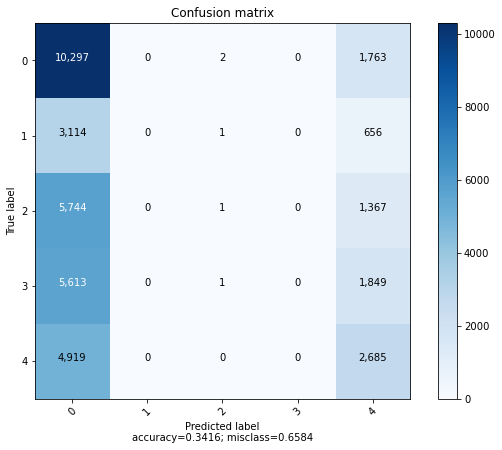

Accuracy: 0.34155 
Balanced accuracy: 0.24138 
Multiclass f1-score: 
    micro: 0.34155 
    macro: 0.16616 
    weighted: 0.22404


Classification report:

              precision    recall  f1-score   support

           0    0.34685   0.85367   0.49328     12062
           1    0.00000   0.00000   0.00000      3771
           2    0.20000   0.00014   0.00028      7112
           3    0.00000   0.00000   0.00000      7463
           4    0.32272   0.35310   0.33723      7604

    accuracy                        0.34155     38012
   macro avg    0.17391   0.24138   0.16616     38012
weighted avg    0.21204   0.34155   0.22404     38012



In [24]:
pipeline.get_scores(test_df[S.TARGET].values, pred)